# Divergence Analysis 

### Imports and paths

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import amplpy
from pathlib import Path

from python.util.return_up_outliers_func import *

In [32]:
# Params for the run and files selection
run_ampl_files = False
is_dbp = True
is_dbb = not is_dbp

In [33]:
# Paths
path_data_network = Path('data_network') 
path_data_DA = Path('results')
path_current = Path('.')

In [34]:
if run_ampl_files :
    ampl = amplpy.AMPL()
    ampl.read_data('detection.run')
    ampl.close()

In [35]:
# Import data from network
df_branches = pd.read_table(path_data_network / 'ampl_network_branches.txt', sep=" ", header=1).drop(columns=["#\"variant\""])
df_buses = pd.read_table(path_data_network / 'ampl_network_buses.txt', sep=" ", header=1).drop(columns=["#\"variant\""])

# Import values from divergence analysis results
df_var_Vtheta = pd.read_csv(path_data_DA / "Vtheta_var.csv", sep=";", header=1)
df_penal_s = pd.read_csv(path_data_DA / "s1_penal.csv", sep=";", header=1)

if (is_dbp):
    sigma_penal_file = "sigma_penal_dbp.csv"
elif (is_dbb):
    sigma_penal_file = "sigma_penal_dbb.csv"
df_penal_sigma = pd.read_csv(path_data_DA / sigma_penal_file, sep=";", header=1)

### Calculation of sets and params for the rest of the analysis

##### About V and theta values

<Axes: >

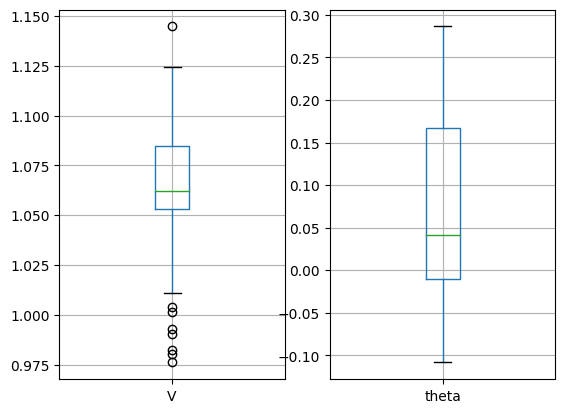

In [36]:
# Boxplot of V/theta values computed
fig, axes = plt.subplots(1,2)
df_var_Vtheta.boxplot(column=['V'], ax=axes.flatten()[0])
df_var_Vtheta.boxplot(column=['theta'], ax=axes.flatten()[1]) 

In [37]:
# Print how many elements are at the bounds
V_min, V_max, theta_min, theta_max = 0.8, 1.2, -3.141592, 3.141592
count_V_min, count_V_max, count_theta_min, count_theta_max = 0, 0, 0, 0
for index, row in df_var_Vtheta.iterrows():
    if row['V'] <= V_min:
        count_V_min += 1
        print("Bus n°" + str(row['bus']) + ", with id " + row['id'] + ", min value of voltage reached.")
    elif row['V'] >= V_max:
        count_V_max += 1
        print("Bus n°" + str(row['bus']) + ", with id " + row['id'] + ", max value of voltage reached.")
    if row['theta'] <= theta_min:
        count_theta_min += 1
        print("Bus n°" + str(row['bus']) + ", with id " + row['id'] + ", min value of theta reached.")
    elif row['theta'] >= theta_max:
        count_theta_max += 1
        print("Bus n°" + str(row['bus']) + ", with id " + row['id'] + ", max value of theta reached.")

print("Total number of buses with min voltage value :", count_V_min)
print("Total number of buses with max voltage value :", count_V_max)
print("Total number of buses with min theta value :", count_theta_min)
print("Total number of buses with max theta value :", count_theta_max)

Total number of buses with min voltage value : 0
Total number of buses with max voltage value : 0
Total number of buses with min theta value : 0
Total number of buses with max theta value : 0


##### About s penalization

   busPV  targetV        V       s1     b_s1  \
0     35  1.08955  1.08955  0.00000  0.00000   
1     88  1.09270  1.12441 -0.03171  0.05341   
2     89  1.07699  1.07699 -0.00000  0.00000   
3    139  1.07727  1.07727  0.00000  0.00000   

                                         id  
0  '5a0f7fcc-edef-4a91-8a3d-7790c2a9b93f_0'  
1  'a389cef8-0f13-4834-b746-db3ccd5eb540_0'  
2  'ab03313f-13a1-4eba-bb7e-eeda44fb6971_0'  
3  '80e5e159-c381-4c9d-b5ab-1473ec023385_0'  


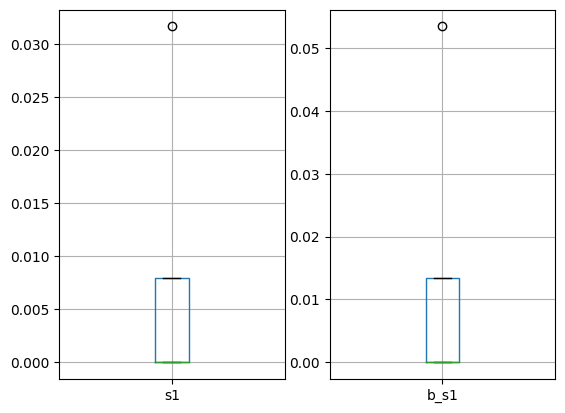

In [38]:
# About s1 penalsiation in all the models
fig, axes = plt.subplots(1,2)
df_penal_s.drop('id',axis=1).abs().boxplot(column=['s1'], ax=axes.flatten()[0])
df_penal_s.drop('id',axis=1).abs().boxplot(column=['b_s1'], ax=axes.flatten()[1])
print(df_penal_s)

About sigma penalization

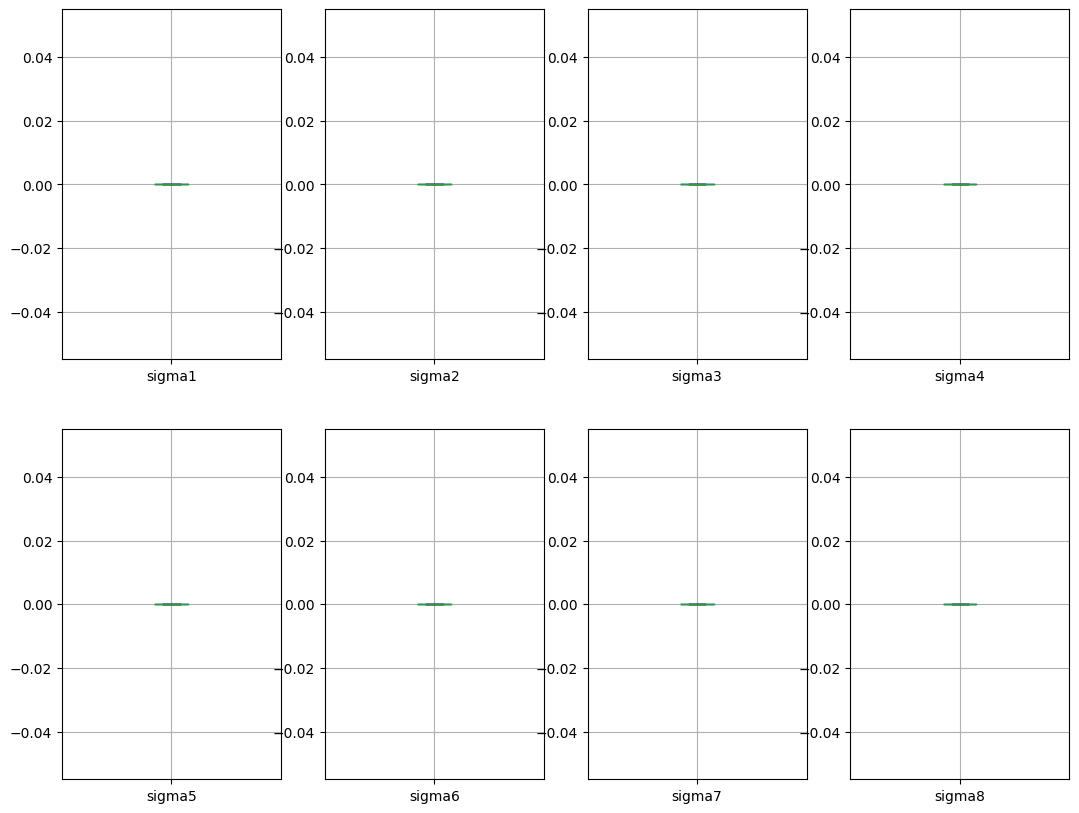

In [39]:
# Sigma penal for all the models
fig, axes = plt.subplots(2,4, figsize=(13,10))
for i in range(1,9):
    df_penal_sigma.boxplot(column=['sigma'+str(i)], ax=axes.flatten()[i-1])

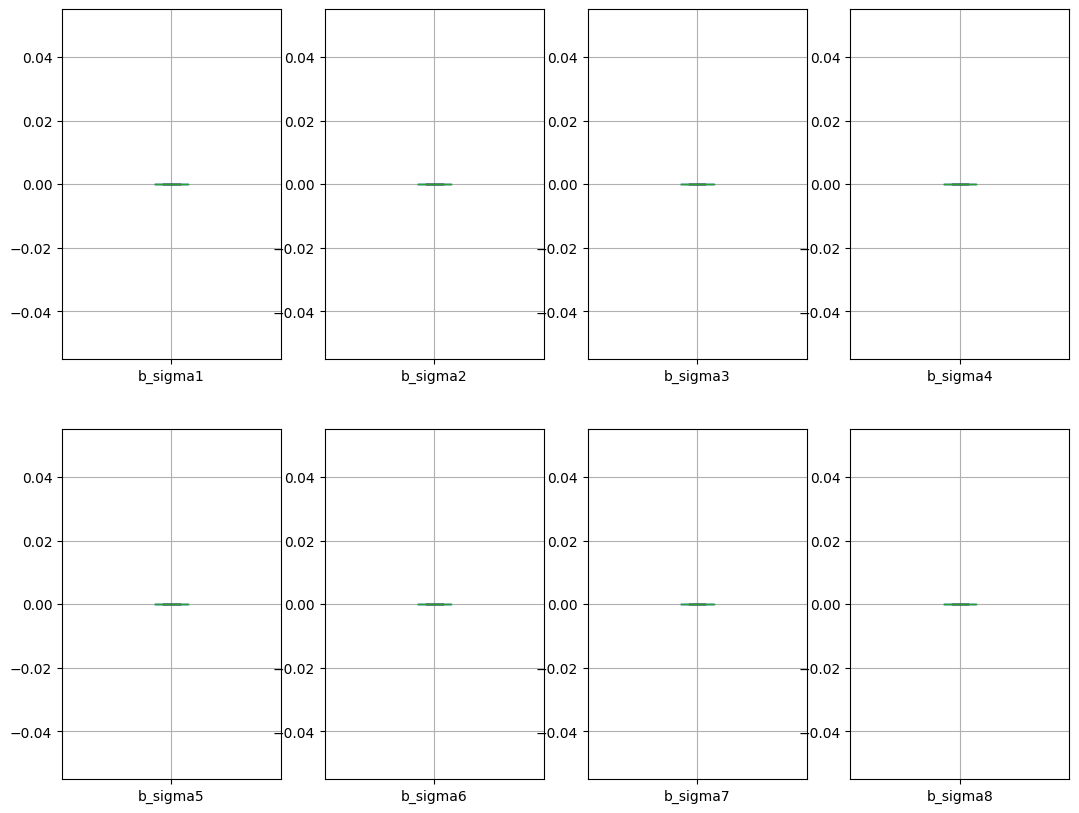

In [40]:
# For detection by params
if (is_dbp):
    fig, axes = plt.subplots(2,4, figsize=(13,10))
    for i in range(1,9):
        df_penal_sigma.boxplot(column=['b_sigma'+str(i)], ax=axes.flatten()[i-1])

# For detection by branches
elif (is_dbb):
    fig, axes = plt.subplots(1,1, figsize=(4,5))
    df_penal_sigma.boxplot(column=['b_branch'])
    print(df_penal_sigma[df_penal_sigma['b_branch']==1])

### Print info about important penalization

In [41]:
# def print_important_branch_penal_IQR(var_penal, df_penal, df_data, threshold, elem_penal):
#     """ Print some information on the penalization of df['elem_penal'] values. """

#     print("# ABOUT {elem_penal} PENALIZATION".format(elem_penal=elem_penal.upper()))
#     for index, element in return_up_outliers_IQR(df_penal[var_penal].abs(), threshold).items():

#         data_index = df_penal['branch'].get(index) - 1 # -1 FIXME ????
#         gap = 100 * element / (df_data[elem_penal].get(data_index)+0.0000001)
#         string = "Branch/transfo n°"
        
#         if 'num' in df_data.keys():
#             string += str(df_data['num'].get(data_index))

#         bus1, bus2 = df_data['bus1'].get(data_index), df_data['bus2'].get(data_index)
#         string += ", between bus " + str(bus1) + " and " + str(bus2)
#         string += " with id \"" + df_data['id'].get(data_index).strip("''")
#         string += "\", important value of penalization : " + str(element) + "   (gap of " + "{:.2f}".format(gap) + "%)"
#         print(string)
#     print()

# def print_important_bus_penal_IQR(var_penal, df_penal, df_data, threshold, elem_penal):
#     """ Print some information on the penalization of df['elem_penal'] values. """

#     print("# ABOUT {elem_penal} PENALIZATION".format(elem_penal=elem_penal.upper()))
#     for index, element in return_up_outliers_IQR(df_penal[var_penal].abs(), threshold).items():
#         gap = 100 * element / (df_data[elem_penal].get(index)+0.0000001)
#         string = "Bus n°" + str(df_penal['busPV'].get(index))
#         string += " with id \"" + df_data['id'].get(index).strip("''")
#         string += "\", important value of penalization : " + str(element) + "   (gap of " + "{:.2f}".format(gap) + "%)"
#         print(string)
#     print()

In [42]:
#threshold = 0.1
#print_important_bus_penal_IQR('s1', df_penal_s, df_penal_s, threshold, 'targetV')
#print_important_branch_penal_IQR("sigma1", df_penal_sigma, df_branches, threshold, 'cst ratio (pu)')
#print_important_branch_penal_IQR("sigma2", df_penal_sigma, df_penal_sigma, threshold, 'admittance')
#print_important_branch_penal_IQR("sigma3", df_penal_sigma, df_penal_sigma, threshold, 'dephor')
#print_important_branch_penal_IQR("sigma4", df_penal_sigma, df_penal_sigma, threshold, 'angper')
#print_important_branch_penal_IQR("sigma5", df_penal_sigma, df_branches, threshold,'g1 (pu)')
#print_important_branch_penal_IQR("sigma6", df_penal_sigma, df_branches, threshold,'b1 (pu)')
#print_important_branch_penal_IQR("sigma7", df_penal_sigma, df_branches, threshold,'g2 (pu)')
#sprint_important_branch_penal_IQR("sigma8", df_penal_sigma, df_branches, threshold,'b2 (pu)')


In [43]:
def print_important_branch_penal_Zscore(var_penal, df_penal, threshold, elem_penal, penal_bus=None):
    """ Print some information on the penalization of df['elem_penal'] values. """

    print("# ABOUT {elem_penal} PENALIZATION".format(elem_penal=elem_penal.upper()))

    for index, element in return_up_outliers_Zscore(df_penal[var_penal].abs(), threshold).items():
        data_index = index 

        gap = 100 * element / (df_penal[elem_penal].get(data_index)+0.0000001)
        string = "Branch/transfo n°"
        
        if 'num' in df_penal.keys():
            string += str(df_penal['num'].get(data_index))
        elif 'branch' in df_penal.keys():
            string += str(df_penal['branch'].get(data_index))

        bus1, bus2 = df_penal['bus1'].get(data_index), df_penal['bus2'].get(data_index)

        if penal_bus != None:
            penal_bus.add(bus1)
            penal_bus.add(bus2)

        string += ", between bus " + str(bus1) + " and " + str(bus2)
        string += " with id \"" + df_penal['id'].get(data_index).strip("''")
        string += "\", important value of penalization : " + str(element) + "   (gap of " + "{:.2f}".format(gap) + "%)"
        print(string)
    print()

def print_important_bus_penal_Zscore(var_penal, df_penal, threshold, elem_penal, penal_bus=None):
    """ Print some information on the penalization of df['elem_penal'] values. """

    print("# ABOUT {elem_penal} PENALIZATION".format(elem_penal=elem_penal.upper()))
    for index, element in return_up_outliers_Zscore(df_penal[var_penal].abs(), threshold).items():
        gap = 100 * element / (df_penal[elem_penal].get(index)+0.0000001)
        string = "Bus n°" + str(df_penal['busPV'].get(index))
        
        if penal_bus != None:
            penal_bus.add(df_penal['busPV'].get(index))

        string += " with id \"" + df_penal['id'].get(index).strip("''")
        string += "\", important value of penalization : " + str(element) + "   (gap of " + "{:.2f}".format(gap) + "%)"
        print(string)
    print()

In [44]:
threshold = 3
penal_buses = set()
print_important_bus_penal_Zscore('s1', df_penal_s, threshold, 'targetV', penal_buses)
print_important_branch_penal_Zscore("sigma1", df_penal_sigma, threshold, 'rho', penal_buses)
print_important_branch_penal_Zscore("sigma2", df_penal_sigma, threshold, 'admittance', penal_buses)
print_important_branch_penal_Zscore("sigma3", df_penal_sigma, threshold, 'dephor', penal_buses)
print_important_branch_penal_Zscore("sigma4", df_penal_sigma, threshold, 'angper', penal_buses)
print_important_branch_penal_Zscore("sigma5", df_penal_sigma, threshold,'g1 (pu)', penal_buses)
print_important_branch_penal_Zscore("sigma6", df_penal_sigma, threshold,'b1 (pu)', penal_buses)
print_important_branch_penal_Zscore("sigma7", df_penal_sigma, threshold,'g2 (pu)', penal_buses)
print_important_branch_penal_Zscore("sigma8", df_penal_sigma, threshold,'b2 (pu)', penal_buses)


# ABOUT TARGETV PENALIZATION

# ABOUT RHO PENALIZATION

# ABOUT ADMITTANCE PENALIZATION

# ABOUT DEPHOR PENALIZATION

# ABOUT ANGPER PENALIZATION

# ABOUT G1 (PU) PENALIZATION

# ABOUT B1 (PU) PENALIZATION

# ABOUT G2 (PU) PENALIZATION

# ABOUT B2 (PU) PENALIZATION



### Exportation of buses with important penalization

In [45]:
# with open(path_data_DA / 'bus_important_penal.txt', 'w') as file:
#     file.write('# Bus with important penal in divergence analysis\n')
#     file.write('# "penal_bus" "bus"\n')
    
#     count = 1
#     for bus in penal_buses:
#         string = "{i} {bus}\n".format(i=count,bus=bus)
#         file.write(string)
#         count += 1
